In [1]:
import numpy as np
import pandas as pd
import os
import statistics

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action = 'ignore')

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train['Time'] = pd.to_datetime(train['Time'])
test['Time'] = pd.to_datetime(test['Time'])

In [11]:
test.head(10)

,Time,NX1301,NX1302,NX1303,NX1304,NX1305,NX1306,NX1307,NX1308,NX1309,NX1310,NX1311,NX1312,NX1313,NX1314,NX1315,NX1316,NX1317,NX1318,NX1319,NX1320,NX1321,NX1322,NX1323,NX1324,NX1325,NX1326,NX1327,NX1328,NX1329,NX1330,NX1331,NX1332,NX1333,NX1334,NX1335,NX1336,NX1337,NX1338,NX1339,NX1340,NX1341,NX1342,NX1343,NX1344,NX1345,NX1346,NX1347,NX1348,NX1349,NX1350,NX1351,NX1352,NX1353,NX1354,NX1355,NX1356,NX1357,NX1358,NX1359,NX1360,NX1361,NX1362,NX1363,NX1364,NX1365,NX1366,NX1367,NX1368,NX1369,NX1370,NX1371,NX1372,NX1373,NX1374,NX1375,NX1376,NX1377,NX1378,NX1379,NX1380,NX1381,NX1382,NX1383,NX1384,NX1385,NX1386,NX1387,NX1388,NX1389,NX1390,NX1391,NX1392,NX1393,NX1394,NX1395,NX1396,NX1397,NX1398,NX1399,NX1400,NX1401,NX1402,NX1403,NX1404,NX1405,NX1406,NX1407,NX1408,NX1409,NX1410,NX1411,NX1412,NX1413,NX1414,NX1415,NX1416,NX1417,NX1418,NX1419,NX1420,NX1421,NX1422,NX1423,NX1424,NX1425,NX1426,NX1427,NX1428,NX1429,NX1430,NX1431,NX1432,NX1433,NX1434,NX1435,NX1436,NX1437,NX1438,NX1439,NX1440,NX1441,NX1442,NX1443,NX1444,NX1445,NX1446,NX1447,NX1448,NX1449,NX1450,NX1451,NX1452,NX1453,NX1454,NX1455,NX1456,NX1457,NX1458,NX1459,NX1460,NX1461,NX1462,NX1463,NX1464,NX1465,NX1466,NX1467,NX1468,NX1469,NX1470,NX1471,NX1472,NX1473,NX1474,NX1475,NX1476,NX1477,NX1478,NX1479,NX1480,NX1481,NX1482,NX1483,NX1484,NX1485,NX1486,NX1487,NX1488,NX1489,NX1490,NX1491,NX1492,NX1493,NX1494,NX1495,NX1496,NX1497,NX1498,NX1499,NX1500,NX_total,month
0,2017-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.273,NaN,0.385,NaN,NaN,NaN,NaN,NaN,0.093,NaN,NaN,NaN,0.305,NaN,NaN,NaN,NaN,NaN,NaN,0.109,NaN,NaN,NaN,NaN,NaN,NaN,0.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.870,NaN,NaN,0.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.231,NaN,NaN,NaN,NaN,NaN,0.038,0.313,NaN,NaN,0.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137,NaN,NaN,0.243,2.181,NaN,NaN,NaN,0.145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.860,NaN,NaN,NaN,NaN,NaN,0.469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275,0.021,NaN,21,7
1,2017-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166,NaN,0.401,NaN,NaN,NaN,NaN,NaN,0.093,NaN,NaN,NaN,0.308,NaN,NaN,NaN,NaN,NaN,NaN,0.143,NaN,NaN,NaN,NaN,NaN,NaN,0.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465,NaN,NaN,0.136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.412,NaN,NaN,NaN,NaN,NaN,0.038,0.321,NaN,NaN,0.068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121,NaN,NaN,0.299,2.121,NaN,NaN,NaN,0.144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.792,NaN,NaN,NaN,NaN,NaN,0.477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.021,NaN,19,7
2,2017-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.164,NaN,0.409,NaN,NaN,NaN,NaN,NaN,0.092,NaN,NaN,NaN,0.344,NaN,NaN,NaN,NaN,NaN,NaN,0.130,NaN,NaN,NaN,NaN,NaN,NaN,0.075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.325,NaN,NaN,0.153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332,NaN,NaN,NaN,NaN,NaN,0.038,0.373,NaN,NaN,0.092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121,NaN,NaN,0.238,1.584,NaN,NaN,NaN,0.143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.837,NaN,NaN,NaN,NaN,NaN,0.483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.157,NaN,NaN,NaN,NaN,NaN,

In [26]:
test.tail(10)

,Time,NX1301,NX1302,NX1303,NX1304,NX1305,NX1306,NX1307,NX1308,NX1309,NX1310,NX1311,NX1312,NX1313,NX1314,NX1315,NX1316,NX1317,NX1318,NX1319,NX1320,NX1321,NX1322,NX1323,NX1324,NX1325,NX1326,NX1327,NX1328,NX1329,NX1330,NX1331,NX1332,NX1333,NX1334,NX1335,NX1336,NX1337,NX1338,NX1339,NX1340,NX1341,NX1342,NX1343,NX1344,NX1345,NX1346,NX1347,NX1348,NX1349,NX1350,NX1351,NX1352,NX1353,NX1354,NX1355,NX1356,NX1357,NX1358,NX1359,NX1360,NX1361,NX1362,NX1363,NX1364,NX1365,NX1366,NX1367,NX1368,NX1369,NX1370,NX1371,NX1372,NX1373,NX1374,NX1375,NX1376,NX1377,NX1378,NX1379,NX1380,NX1381,NX1382,NX1383,NX1384,NX1385,NX1386,NX1387,NX1388,NX1389,NX1390,NX1391,NX1392,NX1393,NX1394,NX1395,NX1396,NX1397,NX1398,NX1399,NX1400,NX1401,NX1402,NX1403,NX1404,NX1405,NX1406,NX1407,NX1408,NX1409,NX1410,NX1411,NX1412,NX1413,NX1414,NX1415,NX1416,NX1417,NX1418,NX1419,NX1420,NX1421,NX1422,NX1423,NX1424,NX1425,NX1426,NX1427,NX1428,NX1429,NX1430,NX1431,NX1432,NX1433,NX1434,NX1435,NX1436,NX1437,NX1438,NX1439,NX1440,NX1441,NX1442,NX1443,NX1444,NX1445,NX1446,NX1447,NX1448,NX1449,NX1450,NX1451,NX1452,NX1453,NX1454,NX1455,NX1456,NX1457,NX1458,NX1459,NX1460,NX1461,NX1462,NX1463,NX1464,NX1465,NX1466,NX1467,NX1468,NX1469,NX1470,NX1471,NX1472,NX1473,NX1474,NX1475,NX1476,NX1477,NX1478,NX1479,NX1480,NX1481,NX1482,NX1483,NX1484,NX1485,NX1486,NX1487,NX1488,NX1489,NX1490,NX1491,NX1492,NX1493,NX1494,NX1495,NX1496,NX1497,NX1498,NX1499,NX1500,NX_total,month
8750,2018-06-30 14:00:00,0.990,0.142,0.319,0.261,0.213,0.431,0.322,0.331,0.261,0.142,0.253,0.188,0.475,0.107,0.437,0.445,0.366,0.178,0.450,8.676,0.447,0.529,0.149,4.491,0.481,0.305,0.387,0.350,0.188,0.192,0.374,0.274,0.083,0.192,0.120,0.463,0.088,0.126,0.346,0.272,0.336,0.887,0.188,0.149,0.533,0.325,0.445,0.395,0.383,0.071,4.966,0.161,0.426,3.191,0.172,0.161,2.399,0.699,0.173,0.481,0.288,0.173,0.269,0.452,0.170,0.058,0.337,0.327,2.423,0.306,20.818,0.304,0.251,0.382,7.261,2.918,1.135,0.174,0.121,0.361,0.180,0.239,0.362,0.185,0.272,0.226,0.255,0.274,0.161,0.223,0.703,0.363,0.538,1.376,9.237,0.372,0.271,0.368,0.258,0.687,0.305,1.297,0.318,6.701,0.227,0.510,1.243,2.721,0.225,3.160,0.166,0.529,0.114,1.047,0.340,0.278,0.695,0.179,4.339,0.537,0.131,0.336,0.534,0.154,0.753,0.352,0.855,0.146,1.877,0.252,0.536,0.390,0.219,0.941,0.231,10.289,0.122,0.245,0.148,0.213,1.704,0.332,0.008,0.161,0.191,0.385,0.317,16.907,0.166,0.320,0.688,0.147,0.094,0.641,0.006,0.813,0.385,0.291,0.397,0.301,0.187,0.406,0.240,1.202,0.070,2.406,5.731,0.304,10.362,0.145,13.257,0.727,0.470,0.119,0.280,0.095,0.382,0.192,0.176,0.161,0.122,0.230,0.149,0.168,1.821,0.718,0.405,0.295,0.061,0.073,0.231,0.373,0.360,0.474,0.312,0.413,0.221,6.833,0.027,0.190,214,6
8751,2018-06-30 15:00:00,1.179,0.211,0.245,0.208,0.188,0.757,0.344,0.345,0.272,0.110,0.239,0.175,0.727,0.239,0.352,0.992,0.219,0.240,0.444,8.824,0.616,0.576,0.155,3.419,0.419,0.399,0.302,0.344,0.187,0.404,0.210,0.268,0.071,0.191,0.122,0.449,0.091,0.261,0.404,0.313,0.262,0.323,0.122,0.140,0.525,0.286,0.460,0.358,0.308,0.070,5.230,0.164,0.515,3.232,0.167,0.143,2.432,0.463,0.171,0.375,0.271,0.208,0.399,0.503,0.242,0.072,0.385,0.321,2.046,0.243,20.879,0.364,0.290,0.380,6.984,1.372,1.115,0.175,0.113,0.276,0.171,0.209,0.404,0.177,0.559,0.260,0.266,0.273,0.086,0.247,0.331,0.352,0.572,1.373,9.559,0.407,0.401,0.346,0.231,0.799,0.908,0.795,0.393,5.630,0.214,0.485,1.097,3.119,0.292,3.204,0.144,0.238,0.195,0.286,0.286,0.136,0.301,0.258,2.784,0.473,0.121,0.162,0.616,0.192,0.519,1.020,0.406,0.149,1.158,0.295,0.582,0.170,0.445,0.535,0.336,12.288,0.125,0.313,0.139,0.231,1.650,0.633,0.009,0.167,0.192,0.325,0.333,17.887,0.248,0.170,0.474,0.149,0.096,0.667,0.006,0.660,0.326,0.365,0.370,0.372,0.188,0.451,0.229,0.648,0.552,2.564,5.731,0.243,11.723,0.107,14.122,0.374,0.405,0.143,0.225,0.096,0.339,0.201,0.297,0.159,0.122,0.236,0.103,0.520,2.135,0.661,0.193,0.231,0.061,0.073,0.213,0.350,0.372,0.422,0.312,0.378,0.197,4.813,0.027,0.178,211,6
8752,2018-06-30 16:00:00,1.703,0.168,0.211,0.207,0.179,0.523,0.316,0.324,0.571,0.301,0.257,0.187,0.470,0.33

In [22]:
def make_sum_column(data) :
    
    data['NX_total'] = [0] * len(data)
    for length in range(len(data)) :
        data['NX_total'][length] = data.iloc[length, 1 : -1].sum()
    
    return data

In [23]:
train = make_sum_column(train)
test = make_sum_column(test)

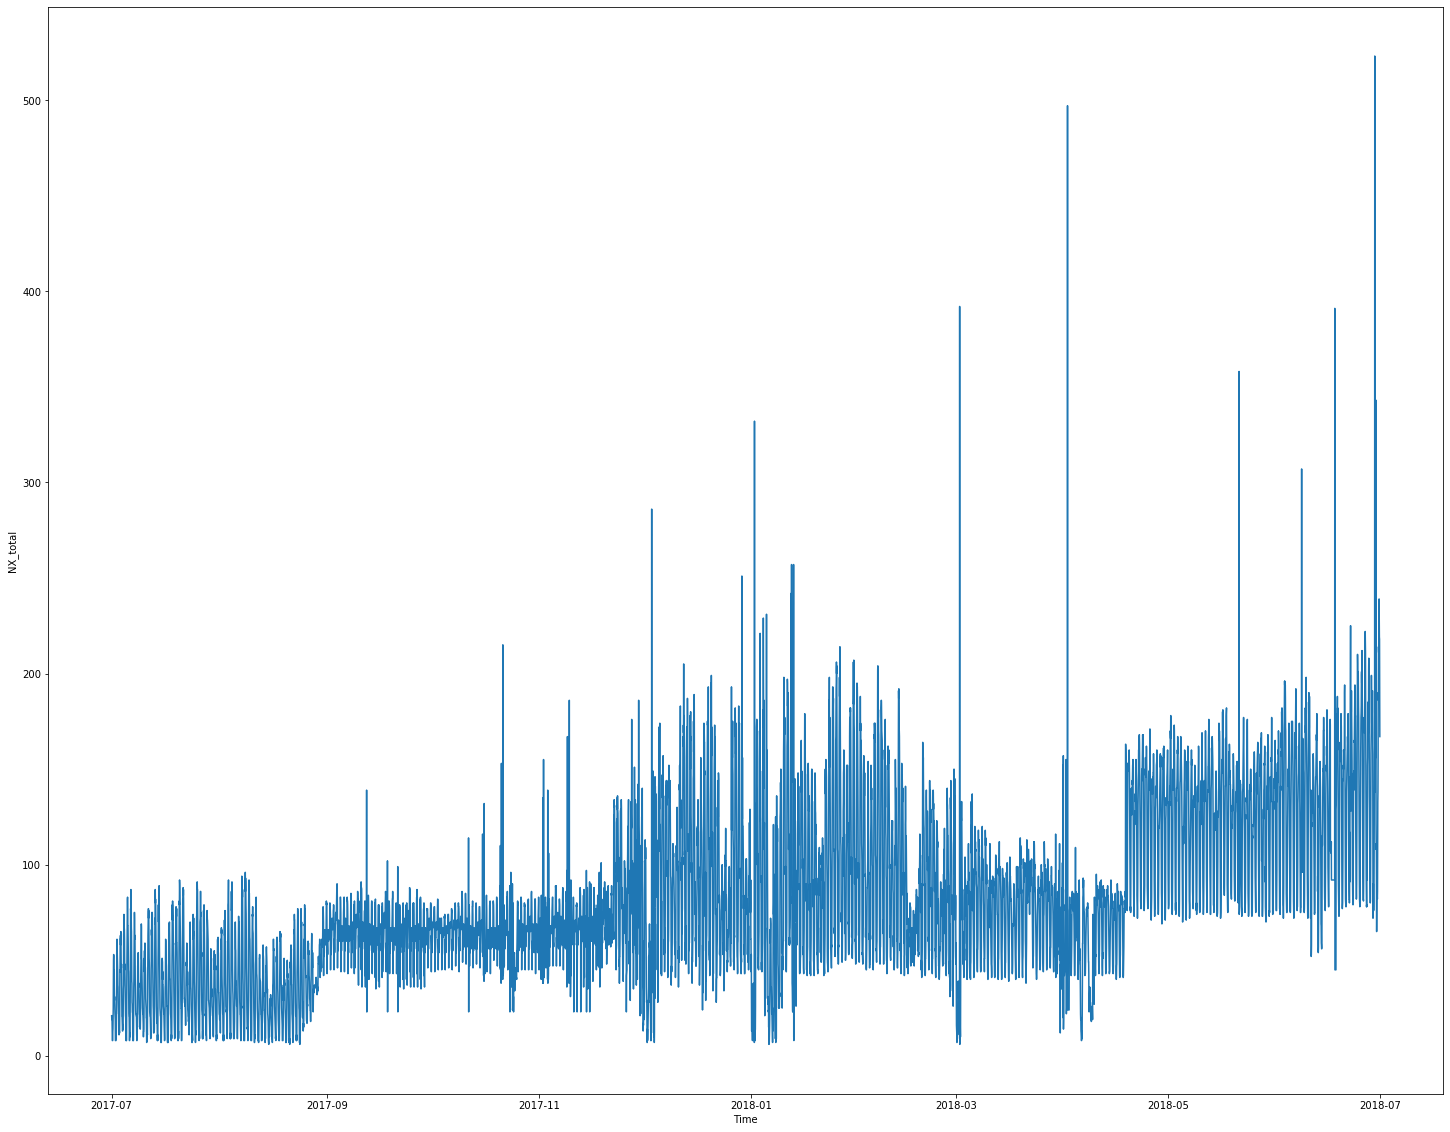

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (25, 20))

sns.lineplot(x = 'Time', y = 'NX_total', ax = ax, data = test)
plt.show()

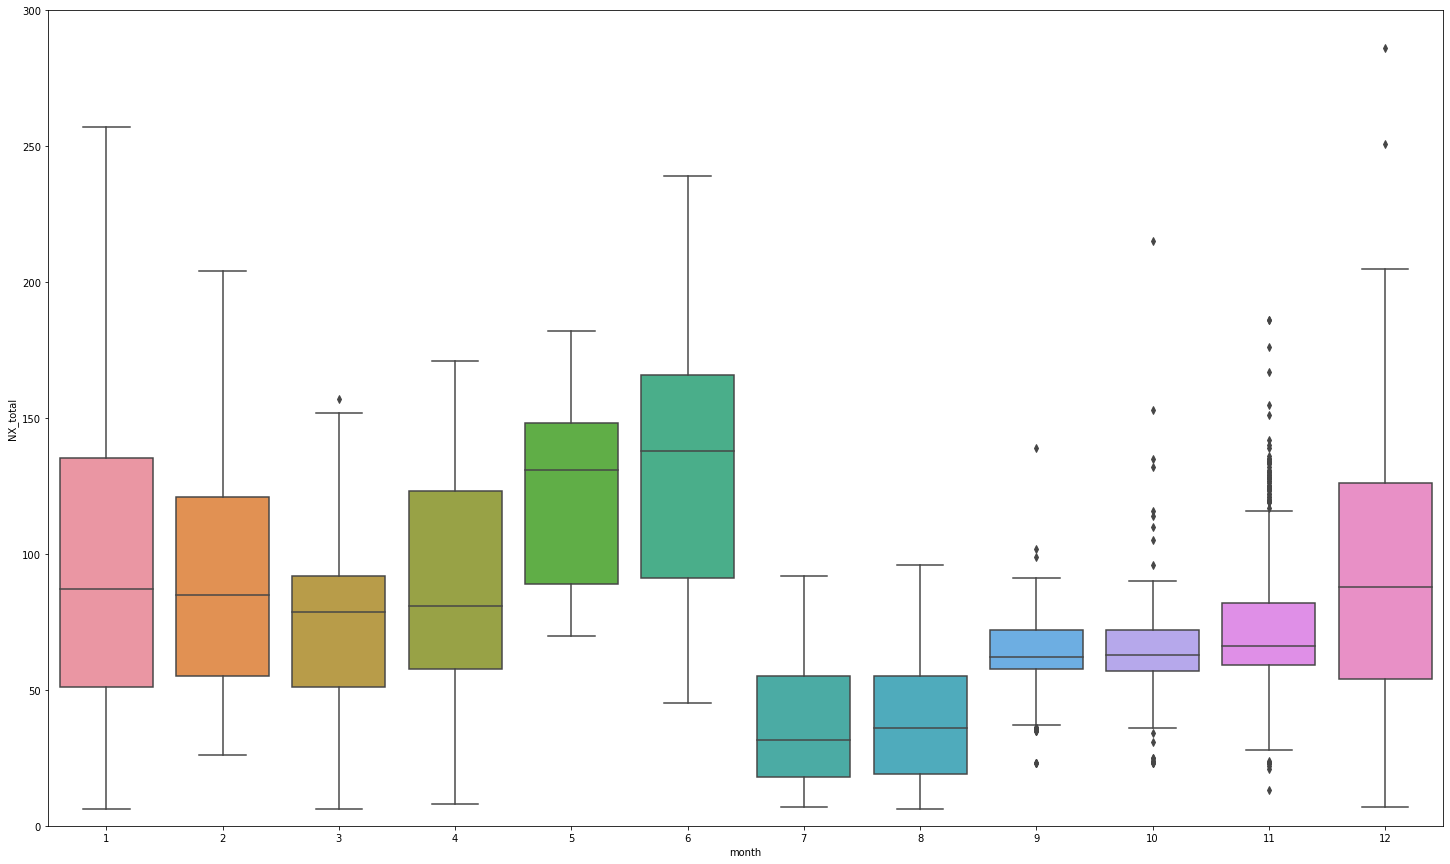

In [27]:
train['month'] = train['Time'].dt.month
test['month'] = test['Time'].dt.month

fig, ax = plt.subplots(1, 1, figsize = (25, 15))

sns.boxplot(x = 'month', y = 'NX_total', ax = ax, data = test)
plt.ylim((0, 300))
plt.show()